## Prepare dependencies

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, DataCollatorWithPadding
import torch
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay, confusion_matrix, roc_curve, auc

## Prepare model

In [ ]:
MODEL_PATH = "../models/distilbert-base-uncased"

tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_PATH)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors='pt')

device = "cuda" if torch.cuda.is_available() else "cpu"

model.eval()
model.to(device)

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


## Prepare test data

In [ ]:
data = load_dataset('csv', data_files={'test': "../datasets/test_data.csv"})
test = data['test']
len(test)

1034

In [4]:
def preprocess_function(examples):
    tokenized = tokenizer(examples['v2'], truncation=True, padding=True)
    tokenized['labels'] = examples['v1']
    return tokenized
        
tokenized_test = test.map(preprocess_function, batched=True)


In [5]:
tokenized_test.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
test_loader = DataLoader(tokenized_test, batch_size=32, collate_fn=data_collator)

## Evaluating

In [6]:
preds = []
labels = []
probs = []

with torch.inference_mode():

    for batch in test_loader:

        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        label = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        prob = torch.softmax(outputs.logits, dim=-1)
        pred = torch.argmax(prob, dim=-1).cpu().numpy()

        preds.extend(pred)
        labels.extend(label.cpu().numpy())
        probs.extend(prob[:,1].cpu().numpy())

## Evaluation results

In [7]:
acc = accuracy_score(labels, preds)

print("Evaluation Results:")
print(f"Accuracy: {acc:.4f}")
print("Classification Report:")
print(classification_report(labels,
                            preds,
                            target_names=['Ham','Spam'],
                            digits=4))

Evaluation Results:
Accuracy: 0.9923
Classification Report:
              precision    recall  f1-score   support

         Ham     0.9933    0.9978    0.9955       889
        Spam     0.9858    0.9586    0.9720       145

    accuracy                         0.9923      1034
   macro avg     0.9895    0.9782    0.9838      1034
weighted avg     0.9922    0.9923    0.9922      1034



### Confusion matrix

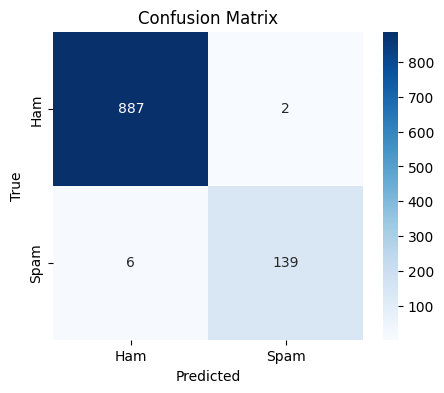

In [8]:
cm = confusion_matrix(labels, preds)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title("Confusion Matrix")
plt.show()

### ROC curve

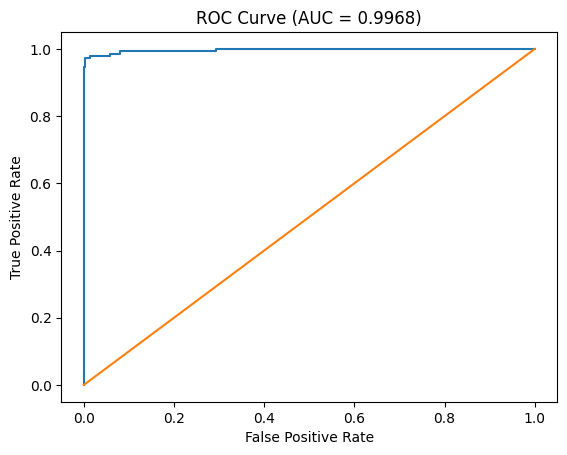

In [9]:
fpr, tpr, _ = roc_curve(labels, probs)
roc_auc = auc(fpr, tpr)
fig_roc, ax_roc = plt.subplots()
ax_roc.plot(fpr, tpr)
ax_roc.plot([0,1], [0,1])
ax_roc.set_xlabel('False Positive Rate')
ax_roc.set_ylabel('True Positive Rate')
ax_roc.set_title(f"ROC Curve (AUC = {roc_auc:.4f})")
plt.show()